In [1]:
# Celda 1: configuración e imports principales

%run ./00_template.py

import os
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import networkx as nx

from shapely.geometry import Point, LineString
try:
    import osmnx as ox
except ImportError as e:
    raise ImportError(
        "Falta osmnx. Instálalo con: pip install osmnx"
    ) from e

ox.settings.log_console = False
ox.settings.use_cache = True

def _ensure_wgs84(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Asegura CRS EPSG:4326 (lat/lon) para trabajar con OSMnx."""
    if gdf.crs is None:
        raise ValueError("GeoDataFrame sin CRS. Define gdf.set_crs(...) antes.")
    if gdf.crs.to_epsg() != 4326:
        return gdf.to_crs(4326)
    return gdf


print("Notebook 03 – Accesibilidad a servicios")
print(f"Geodatabase utilizada: {RUTA_GPKG}")


=== Template PEP1 Desiertos cargado ===
BASE_DIR        : /home/jovyan
CARGA_DIR       : /home/jovyan/data/raw/Carga de datos
RUTA_GPKG       : /home/jovyan/data/raw/Carga de datos/geodatabase_proyecto.gpkg
RUTA_CENSO_CSV  : /home/jovyan/data/raw/Carga de datos/censo_RM_totales_comuna.csv
Notebook 03 – Accesibilidad a servicios
Geodatabase utilizada: /home/jovyan/data/raw/Carga de datos/geodatabase_proyecto.gpkg


In [2]:
import os
import requests
from datetime import datetime
from dateutil import parser as dtparser  # pip: python-dateutil

OTP_URL = os.getenv("OTP_URL", "http://otp:8080").rstrip("/")
OTP_GTFS_GQL = f"{OTP_URL}/otp/gtfs/v1"

def otp_plan_connection(
    o_lat: float, o_lon: float,
    d_lat: float, d_lon: float,
    earliest_departure_iso: str = "2025-12-25T08:30-03:00",
    transit_modes=("BUS", "SUBWAY", "RAIL"),
    timeout=60
):
    """
    Llama a OTP GraphQL (gtfs/v1) usando planConnection.
    Retorna JSON dict (o levanta excepción si OTP falla).
    """
    # OJO: CoordinateValue es SCALAR, pero OTP lo acepta como número en variables.
    query = """
    query($oLat: CoordinateValue!, $oLon: CoordinateValue!, $dLat: CoordinateValue!, $dLon: CoordinateValue!) {
      planConnection(
        origin: { location: { coordinate: { latitude: $oLat, longitude: $oLon } } }
        destination: { location: { coordinate: { latitude: $dLat, longitude: $dLon } } }
        dateTime: { earliestDeparture: "%s" }
        modes: {
          direct: [WALK]
          transit: { transit: [%s] }
        }
      ) {
        edges {
          node {
            start
            end
            legs {
              mode
              from { name lat lon }
              to   { name lat lon }
            }
          }
        }
      }
    }
    """ % (
        earliest_departure_iso,
        ", ".join([f"{{ mode: {m} }}" for m in transit_modes])
    )

    payload = {
        "query": query,
        "variables": {
            "oLat": o_lat, "oLon": o_lon,
            "dLat": d_lat, "dLon": d_lon
        }
    }

    r = requests.post(OTP_GTFS_GQL, json=payload, timeout=timeout)
    r.raise_for_status()
    data = r.json()
    if "errors" in data:
        raise RuntimeError(data["errors"])
    return data

def otp_best_duration_minutes(resp_json: dict) -> float | None:
    """
    A partir del JSON de planConnection, devuelve el menor tiempo (minutos),
    o None si no hay rutas.
    """
    edges = resp_json.get("data", {}).get("planConnection", {}).get("edges", [])
    if not edges:
        return None

    best = None
    for e in edges:
        node = e["node"]
        start = dtparser.isoparse(node["start"])
        end = dtparser.isoparse(node["end"])
        minutes = (end - start).total_seconds() / 60.0
        if best is None or minutes < best:
            best = minutes
    return best


In [3]:
# Celda 2: carga de comunas y definición de servicios a analizar

LAYER_COMUNAS = "comunas_rm_censo"

# Capas de servicios clave
SERVICE_LAYERS = {
    "salud": "establecimientos_salud",
    "educacion_escolar": "establecimientos_educacion",
    "educacion_superior": "establecimientos_educacion_superior",
    "supermercados": "osm_supermercados",
    "almacenes_barrio": "osm_almacenes_barrio",
}

# Capa de comunas
comunas = gpd.read_file(RUTA_GPKG, layer=LAYER_COMUNAS)

print("Columnas disponibles en comunas_rm_censo:")
print(comunas.columns)

# Verificar CRS
print("\nCRS comunas:", comunas.crs)


Columnas disponibles en comunas_rm_censo:
Index(['CUT_REG', 'CUT_PROV', 'CUT_COM', 'REGION', 'PROVINCIA', 'COMUNA',
       'SUPERFICIE', 'Código comuna', 'Población censada', 'Hombres',
       'Mujeres', 'geometry'],
      dtype='object')

CRS comunas: EPSG:32719


In [ ]:
# Celda 2.2: Construcción / carga de grafos (walk y drive)

GRAPHS_DIR = PROCESSED_DATA / "graphs"
GRAPHS_DIR.mkdir(parents=True, exist_ok=True)

WALK_GRAPH_PATH = GRAPHS_DIR / "graph_walk.graphml"
DRIVE_GRAPH_PATH = GRAPHS_DIR / "graph_drive.graphml"

# Importante: comunas ya debe existir desde tu Celda 2.
comunas_wgs = _ensure_wgs84(comunas)

# Tomamos un bounding box del conjunto de comunas (con un pequeño margen)
minx, miny, maxx, maxy = comunas_wgs.total_bounds
pad = 0.02  # ~2km-ish (depende latitud), ajustable
north, south, east, west = maxy + pad, miny - pad, maxx + pad, minx - pad


def _build_walk_graph(north, south, east, west):
    G = ox.graph_from_bbox(north, south, east, west, network_type="walk", simplify=True)
    # length ya viene (m). Creamos travel_time para caminar:
    walk_speed_kmh = 4.8
    walk_speed_mps = walk_speed_kmh * 1000 / 3600
    for u, v, k, data in G.edges(keys=True, data=True):
        length_m = data.get("length", None)
        if length_m is None:
            continue
        data["travel_time"] = length_m / walk_speed_mps  # segundos
    return G


def _build_drive_graph(north, south, east, west):
    G = ox.graph_from_bbox(north, south, east, west, network_type="drive", simplify=True)
    # OSMnx puede estimar velocidades y tiempo de viaje
    G = ox.add_edge_speeds(G)         # km/h estimados
    G = ox.add_edge_travel_times(G)   # segundos
    return G


def load_or_build_graphs():
    if WALK_GRAPH_PATH.exists():
        G_walk = ox.load_graphml(WALK_GRAPH_PATH)
    else:
        G_walk = _build_walk_graph(north, south, east, west)
        ox.save_graphml(G_walk, WALK_GRAPH_PATH)

    if DRIVE_GRAPH_PATH.exists():
        G_drive = ox.load_graphml(DRIVE_GRAPH_PATH)
    else:
        G_drive = _build_drive_graph(north, south, east, west)
        ox.save_graphml(G_drive, DRIVE_GRAPH_PATH)

    return G_walk, G_drive


G_walk, G_drive = load_or_build_graphs()

print("✅ Grafos listos:")
print(" - walk nodes/edges:", len(G_walk.nodes), len(G_walk.edges))
print(" - drive nodes/edges:", len(G_drive.nodes), len(G_drive.edges))
print("📁 Guardados en:", GRAPHS_DIR)


In [ ]:
# Celda 2.3: Cargar servicios y crear índice espacial

# Ejemplo: reemplaza por tus nombres reales (los de tu Celda 2)
SERVICE_LAYERS = [
    "supermercados",
    "salud",
    "colegios",
    "comisarias",
    "areas_verdes",
    "estadios",
]

def load_services_from_gpkg(layers: list[str]) -> gpd.GeoDataFrame:
    gdfs = []
    for lyr in layers:
        try:
            g = gpd.read_file(RUTA_GPKG, layer=lyr)
        except Exception as e:
            print(f"⚠️ No pude cargar layer '{lyr}': {e}")
            continue

        if g.empty:
            continue

        if g.crs is None:
            # Si tus capas vienen sin CRS, aquí debes setear el correcto
            # g = g.set_crs(4326)
            raise ValueError(f"La capa {lyr} viene sin CRS. Arréglala en el gpkg o set_crs aquí.")

        g = _ensure_wgs84(g)
        g = g[g.geometry.notna()].copy()
        g = g[g.geometry.geom_type.isin(["Point", "MultiPoint"])].copy()

        g["categoria"] = lyr
        gdfs.append(g[["categoria", "geometry"]])

    if not gdfs:
        raise ValueError("No se cargó ninguna capa de servicios. Revisa SERVICE_LAYERS y RUTA_GPKG.")

    servicios = pd.concat(gdfs, ignore_index=True)
    servicios = gpd.GeoDataFrame(servicios, geometry="geometry", crs="EPSG:4326")
    return servicios


servicios = load_services_from_gpkg(SERVICE_LAYERS)

# Índice espacial
servicios_sindex = servicios.sindex

print("✅ Servicios cargados:", len(servicios))
print(servicios["categoria"].value_counts())


In [ ]:
# Celda 2.4: Consulta dinámica por punto (walk/drive)

def _nearest_graph_node(G, point: Point) -> int:
    """Encuentra el nodo más cercano en el grafo a un punto WGS84."""
    return ox.distance.nearest_nodes(G, X=point.x, Y=point.y)

def _candidate_services(point: Point, radius_m: float = 2000, k: int = 10) -> gpd.GeoDataFrame:
    """
    Filtra servicios candidatos por radio (aprox) usando buffer en CRS métrico.
    """
    # Pasamos a CRS métrico para buffer (EPSG:3857 sirve para aproximación)
    p = gpd.GeoSeries([point], crs="EPSG:4326").to_crs(3857).iloc[0]
    buf = p.buffer(radius_m)

    servicios_3857 = servicios.to_crs(3857)
    # sindex en 3857 sería ideal, pero para simpleza usamos el bbox del buffer en 4326 via bounds
    # Haremos filtro rápido bbox en 4326 y luego distancia real en 3857.
    minx, miny, maxx, maxy = gpd.GeoSeries([buf], crs=3857).to_crs(4326).total_bounds

    idx = list(servicios_sindex.intersection((minx, miny, maxx, maxy)))
    cand = servicios.iloc[idx].copy()
    if cand.empty:
        return cand

    cand_3857 = cand.to_crs(3857)
    cand_3857["dist_eucl_m"] = cand_3857.distance(p)
    cand_3857 = cand_3857.sort_values("dist_eucl_m").head(k)

    return cand_3857.to_crs(4326)

def _route_time_seconds(G, origin: Point, dest: Point, weight: str = "travel_time"):
    """
    Retorna (segundos, ruta_nodes) o (np.inf, None) si falla.
    """
    try:
        o = _nearest_graph_node(G, origin)
        d = _nearest_graph_node(G, dest)
        route = nx.shortest_path(G, o, d, weight=weight)
        # sumar pesos
        secs = 0.0
        for u, v in zip(route[:-1], route[1:]):
            data = min(G.get_edge_data(u, v).values(), key=lambda x: x.get(weight, np.inf))
            secs += float(data.get(weight, np.inf))
        return secs, route
    except Exception:
        return np.inf, None

def _route_geometry(G, route_nodes: list[int]) -> LineString | None:
    """Convierte lista de nodos a LineString (lon, lat)."""
    if route_nodes is None:
        return None
    coords = [(G.nodes[n]["x"], G.nodes[n]["y"]) for n in route_nodes]
    if len(coords) < 2:
        return None
    return LineString(coords)

def query_point_desert(lat: float, lon: float, mode: str = "walk",
                       radius_m: float = 2000, k: int = 10,
                       per_category: bool = True) -> gpd.GeoDataFrame:
    """
    Calcula accesibilidad por red desde un punto a servicios cercanos.

    Parámetros
    - lat, lon: ubicación origen en WGS84
    - mode: "walk" o "drive"
    - radius_m: radio para buscar candidatos (prefiltro)
    - k: máximo de candidatos a evaluar
    - per_category: si True, devuelve el mejor servicio por categoría (más accesible)

    Retorna
    - GeoDataFrame con: categoria, tiempo_min, tiempo_s, ruta_geom
    """
    origin = Point(lon, lat)

    cand = _candidate_services(origin, radius_m=radius_m, k=k)
    if cand.empty:
        return gpd.GeoDataFrame(columns=["categoria", "tiempo_min", "tiempo_s", "geometry"], crs="EPSG:4326")

    G = G_walk if mode == "walk" else G_drive

    rows = []
    for _, r in cand.iterrows():
        dest = r.geometry
        secs, route_nodes = _route_time_seconds(G, origin, dest, weight="travel_time")
        geom = _route_geometry(G, route_nodes)

        rows.append({
            "categoria": r["categoria"],
            "tiempo_s": secs,
            "tiempo_min": secs / 60 if np.isfinite(secs) else np.inf,
            "ruta_geom": geom,
            "geometry": dest
        })

    out = gpd.GeoDataFrame(rows, geometry="geometry", crs="EPSG:4326")
    out = out.replace([np.inf, -np.inf], np.nan).dropna(subset=["tiempo_s"])

    if out.empty:
        return out

    if per_category:
        out = out.sort_values("tiempo_s").groupby("categoria", as_index=False).head(1)

    return out.sort_values("tiempo_s")

# Test
# Test: elige un punto cualquiera (Santiago centro aprox)
res_walk = query_point_desert(lat=-33.45, lon=-70.65, mode="walk", radius_m=2000, k=20)
res_drive = query_point_desert(lat=-33.45, lon=-70.65, mode="drive", radius_m=4000, k=30)

display(res_walk[["categoria", "tiempo_min"]])
display(res_drive[["categoria", "tiempo_min"]])


In [ ]:
# Celda 2.5

import os
OTP_URL = "http://localhost:8080"
OTP_PLAN_ENDPOINT = f"{OTP_URL}/otp/routers/default/plan"

def otp_plan(from_lat, from_lon, to_lat, to_lon, date="2025-12-25", time="08:30am",
             mode="TRANSIT,WALK", max_walk_distance=1500, num_itineraries=1, timeout_s=25):
    """
    Llama a OTP y retorna el JSON de planificación.
    Nota: date/time son importantes en GTFS (horarios).
    """
    params = {
        "fromPlace": f"{from_lat},{from_lon}",
        "toPlace": f"{to_lat},{to_lon}",
        "date": date,          # YYYY-MM-DD
        "time": time,          # hh:mma (ej 08:30am)
        "mode": mode,          # TRANSIT,WALK es típico
        "maxWalkDistance": max_walk_distance,
        "numItineraries": num_itineraries
    }
    r = requests.get(OTP_PLAN_ENDPOINT, params=params, timeout=timeout_s)
    r.raise_for_status()
    return r.json()

def otp_best_itinerary_minutes(plan_json):
    """
    Extrae duración (min) del mejor itinerario.
    """
    itineraries = plan_json.get("plan", {}).get("itineraries", [])
    if not itineraries:
        return None, None
    it = itineraries[0]
    dur_s = it.get("duration", None)
    if dur_s is None:
        return None, None
    return dur_s, dur_s / 60.0

def otp_itinerary_geometry(plan_json):
    """
    OTP entrega geometrías por leg (polyline encoded) o sometimes sin geometría.
    Para no complicar con decodificación, aquí armamos una línea simple uniendo paradas.
    (Si quieres la polyline real, te la dejo después.)
    """
    itineraries = plan_json.get("plan", {}).get("itineraries", [])
    if not itineraries:
        return None

    it = itineraries[0]
    legs = it.get("legs", [])
    coords = []
    for leg in legs:
        # from / to tienen lat/lon
        f = leg.get("from", {})
        t = leg.get("to", {})
        if "lat" in f and "lon" in f:
            coords.append((f["lon"], f["lat"]))
        if "lat" in t and "lon" in t:
            coords.append((t["lon"], t["lat"]))

    coords = [c for i, c in enumerate(coords) if i == 0 or c != coords[i-1]]
    if len(coords) < 2:
        return None
    return LineString(coords)

In [ ]:
# Celda 2.6
import numpy as np

def query_point_desert_transit(lat: float, lon: float,
                               radius_m: float = 4000, k: int = 15,
                               per_category: bool = True,
                               date="2025-12-25", time="08:30am",
                               max_walk_distance=1500):
    """
    Consulta de "micro" (transit) usando OTP.
    Devuelve mejor servicio por categoría (si per_category=True).
    """
    origin = Point(lon, lat)

    # Usa TU función de candidatos que ya creaste para walk/drive.
    # Si no la tienes como función, usa la misma lógica (sindex + buffer).
    cand = _candidate_services(origin, radius_m=radius_m, k=k)
    if cand.empty:
        return gpd.GeoDataFrame(columns=["categoria", "tiempo_s", "tiempo_min", "ruta_geom", "geometry"], crs="EPSG:4326")

    rows = []
    for _, r in cand.iterrows():
        dest = r.geometry
        cat = r["categoria"]

        try:
            plan = otp_plan(
                from_lat=lat, from_lon=lon,
                to_lat=dest.y, to_lon=dest.x,
                date=date, time=time,
                mode="TRANSIT,WALK",
                max_walk_distance=max_walk_distance,
                num_itineraries=1
            )
            dur_s, dur_min = otp_best_itinerary_minutes(plan)
            geom = otp_itinerary_geometry(plan)

            if dur_s is None:
                continue

            rows.append({
                "categoria": cat,
                "tiempo_s": float(dur_s),
                "tiempo_min": float(dur_min),
                "ruta_geom": geom,
                "geometry": dest
            })

        except Exception:
            # si OTP no encuentra ruta o hay error, saltamos
            continue

    out = gpd.GeoDataFrame(rows, geometry="geometry", crs="EPSG:4326")
    if out.empty:
        return out

    if per_category:
        out = out.sort_values("tiempo_s").groupby("categoria", as_index=False).head(1)

    return out.sort_values("tiempo_s")


In [3]:
# Celda 3: creación de centroids de comunas y DataFrame base de accesibilidad

# Copia para evitar modificar el original
comunas_acc = comunas.copy()

# Centroides en el mismo CRS (EPSG:32719, unidades en metros)
comunas_acc["centroid"] = comunas_acc.geometry.centroid

# DataFrame base con identificador, nombre y población
COL_POBLACION = "Población censada"

accesibilidad = comunas_acc[["CUT_COM", "COMUNA", COL_POBLACION]].copy()
accesibilidad = accesibilidad.rename(
    columns={
        "CUT_COM": "cod_comuna",
        "COMUNA": "comuna",
        COL_POBLACION: "poblacion",
    }
)

accesibilidad.head()


,cod_comuna,comuna,poblacion
0,13130,San Miguel,150829
1,13118,Macul,123800
2,13119,Maipú,503635
3,13123,Providencia,143974
4,13131,San Ramón,76002


In [ ]:
# Celda 4: función para calcular distancia mínima desde centroides a un servicio

def distancia_minima_a_servicio(
    comunas_gdf: gpd.GeoDataFrame,
    layer_servicio: str,
) -> pd.Series:
    """
    Calcula la distancia mínima (en metros) desde el centroide de cada comuna
    al punto más cercano de una capa de servicios.
    
    comunas_gdf debe contener una columna 'centroid' en el mismo CRS
    que la capa de servicios.
    """
    servicios = gpd.read_file(RUTA_GPKG, layer=layer_servicio)
    servicios = servicios.to_crs(comunas_gdf.crs)

    # Solo geometría de servicios
    servicio_geom = servicios.geometry

    distancias_m = []
    for geom in comunas_gdf["centroid"]:
        # Distancia mínima a cualquier servicio
        d = servicio_geom.distance(geom).min()
        distancias_m.append(d)

    return pd.Series(distancias_m, index=comunas_gdf.index)


In [ ]:
from functools import lru_cache
import numpy as np

@lru_cache(maxsize=50_000)
def _otp_cached(o_lat, o_lon, d_lat, d_lon, departure_iso, modes_key):
    # cachea para no repetir llamadas idénticas
    modes = tuple(modes_key.split(","))
    resp = otp_plan_connection(o_lat, o_lon, d_lat, d_lon, earliest_departure_iso=departure_iso, transit_modes=modes)
    return otp_best_duration_minutes(resp)

def tiempo_minimo_a_servicio_otp(
    comunas_gdf,
    servicios_gdf,
    k: int = 5,
    departure_iso: str = "2025-12-25T08:30-03:00",
    transit_modes=("BUS", "SUBWAY", "RAIL")
):
    """
    Para cada comuna, calcula el menor tiempo (min) hacia servicios usando OTP,
    evaluando solo los k servicios más cercanos (por distancia euclidiana) para reducir llamadas.
    Retorna pd.Series (minutos).
    """
    # Asegurar CRS métrico para el prefiltrado por distancia
    comunas_m = comunas_gdf.to_crs(epsg=3857).copy()
    servicios_m = servicios_gdf.to_crs(epsg=3857).copy()

    # Centroides de comunas
    comunas_m["centroid"] = comunas_m.geometry.centroid

    # Para OTP necesitamos lat/lon reales:
    comunas_ll = comunas_gdf.to_crs(epsg=4326).copy()
    servicios_ll = servicios_gdf.to_crs(epsg=4326).copy()
    comunas_ll["centroid"] = comunas_ll.geometry.centroid

    # Coordenadas servicio (para iterar)
    serv_coords_ll = np.array([(p.y, p.x) for p in servicios_ll.geometry])  # (lat, lon)

    out = []
    modes_key = ",".join(transit_modes)

    for idx, row in comunas_m.iterrows():
        c = row["centroid"]

        # distancias euclidianas a TODOS los servicios (en 3857)
        dists = servicios_m.geometry.distance(c).to_numpy()
        # índices de los k más cercanos
        nearest_idx = np.argsort(dists)[:k]

        # coord comuna (lat, lon)
        c_ll = comunas_ll.loc[idx, "centroid"]
        o_lat, o_lon = float(c_ll.y), float(c_ll.x)

        best = None
        for j in nearest_idx:
            d_lat, d_lon = map(float, serv_coords_ll[j])

            try:
                minutes = _otp_cached(o_lat, o_lon, d_lat, d_lon, departure_iso, modes_key)
            except Exception:
                minutes = None

            if minutes is not None and (best is None or minutes < best):
                best = minutes

        out.append(best)

    return pd.Series(out, index=comunas_gdf.index, name="t_min_otp_min")


In [ ]:
# Celda 5: cálculo de distancias mínimas (en metros y kilómetros)

DEPARTURE_ISO = "2025-12-25T08:30-03:00"  # ajusta si quieres
OTP_MODES = ("BUS", "SUBWAY", "RAIL")     # o solo ("BUS",)

for nombre_logico, capa in SERVICE_LAYERS.items():
    # Distancia mínima (como ya lo tenías)
    serie_m = distancia_minima_a_servicio(comunas_acc, capa)
    accesibilidad[f"dist_min_{nombre_logico}_m"] = serie_m
    accesibilidad[f"dist_min_{nombre_logico}_km"] = serie_m / 1000.0

    # Tiempo mínimo por OTP (minutos)
    tmin = tiempo_minimo_a_servicio_otp(
        comunas_acc,
        capa,
        k=5,
        departure_iso=DEPARTURE_ISO,
        transit_modes=OTP_MODES
    )
    accesibilidad[f"t_min_{nombre_logico}_min"] = tmin

accesibilidad.head()


,cod_comuna,comuna,poblacion,dist_min_salud_m,dist_min_salud_km,dist_min_educacion_escolar_m,dist_min_educacion_escolar_km,dist_min_educacion_superior_m,dist_min_educacion_superior_km,dist_min_supermercados_m,dist_min_supermercados_km,dist_min_almacenes_barrio_m,dist_min_almacenes_barrio_km
0,13130,San Miguel,150829,209.580292,0.209580,268.395874,0.268396,787.870625,0.787871,618.459654,0.618460,269.673391,0.269673
1,13118,Macul,123800,560.066899,0.560067,370.723903,0.370724,1068.032734,1.068033,916.544025,0.916544,169.592343,0.169592
2,13119,Maipú,503635,1354.267884,1.354268,1143.418465,1.143418,4750.824494,4.750824,1035.559522,1.035560,1756.884815,1.756885
3,13123,Providencia,143974,134.779102,0.134779,253.566854,0.253567,211.522157,0.211522,449.583932,0.449584,141.805485,0.141805
4,13131,San Ramón,76002,319.625794,0.319626,328.851762,0.328852,2622.376203,2.622376,591.727398,0.591727,434.959748,0.434960


In [6]:
# Celda 6: comunas con mayor distancia a algunos servicios

columnas_dist_km = [
    "dist_min_salud_km",
    "dist_min_supermercados_km",
    "dist_min_educacion_escolar_km",
]

resumen_distancias = accesibilidad[["comuna"] + columnas_dist_km].copy()

print("Comunas con mayor distancia mínima a un establecimiento de salud:")
resumen_distancias.sort_values("dist_min_salud_km", ascending=False).head(10)


Comunas con mayor distancia mínima a un establecimiento de salud:


,comuna,dist_min_salud_km,dist_min_supermercados_km,dist_min_educacion_escolar_km
41,San José de Maipo,14.090088,24.685087,16.209187
16,Colina,6.555741,19.382245,6.157652
39,Lo Barnechea,5.400339,13.799737,11.351549
47,Padre Hurtado,5.305247,4.058780,0.731568
45,Tiltil,5.263391,25.622240,4.966839
32,Curacaví,4.889422,5.724926,0.015401
11,Pirque,4.325591,11.035672,3.868579
40,Alhué,4.169420,40.794778,4.018674
50,San Pedro,4.081953,35.363096,1.644063
6,Isla de Maipo,3.982711,8.126670,2.332150


In [7]:
# Celda 7: función para calcular cobertura espacial mediante buffers

def cobertura_por_buffers(
    comunas_gdf: gpd.GeoDataFrame,
    layer_servicio: str,
    radio_m: float,
) -> pd.DataFrame:
    """
    Calcula, para cada comuna, el porcentaje de su superficie que está
    dentro de un buffer de radio 'radio_m' alrededor de los servicios.
    
    Retorna un DataFrame con columnas:
    ['cod_comuna', 'area_total_m2', 'area_cubierta_m2', 'porc_cubierto'].
    """
    servicios = gpd.read_file(RUTA_GPKG, layer=layer_servicio)
    servicios = servicios.to_crs(comunas_gdf.crs)

    # Buffers alrededor de cada servicio
    buffers = servicios.buffer(radio_m)

    # Unión de todos los buffers en una sola geometría
    buffer_union = gpd.GeoSeries([buffers.unary_union], crs=comunas_gdf.crs)

    # GeoDataFrame de comunas (copias)
    comunas_local = comunas_gdf[["CUT_COM", "geometry"]].copy()
    comunas_local["area_total_m2"] = comunas_local.geometry.area

    # Intersección entre comunas y la zona cubierta por buffers
    buffer_gdf = gpd.GeoDataFrame(geometry=buffer_union, crs=comunas_gdf.crs)
    intersec = gpd.overlay(comunas_local, buffer_gdf, how="intersection")

    intersec["area_cubierta_m2"] = intersec.geometry.area

    # Agregar por comuna
    resumen = (
        intersec.groupby("CUT_COM")[["area_cubierta_m2"]]
        .sum()
        .reset_index()
    )

    resultado = comunas_local.merge(resumen, on="CUT_COM", how="left")
    resultado["area_cubierta_m2"] = resultado["area_cubierta_m2"].fillna(0.0)
    resultado["porc_cubierto"] = (
        resultado["area_cubierta_m2"] / resultado["area_total_m2"] * 100.0
    )

    resultado = resultado.rename(columns={"CUT_COM": "cod_comuna"})
    return resultado[["cod_comuna", "area_total_m2", "area_cubierta_m2", "porc_cubierto"]]


In [8]:
# Celda 8: cálculo de cobertura con buffers para salud y supermercados

# Radios de ejemplo (puedes ajustarlos según tu enfoque metodológico)
RADIO_SALUD_M = 1200   # 1,2 km
RADIO_SUPERMERCADOS_M = 800  # 0,8 km

cov_salud = cobertura_por_buffers(comunas, "establecimientos_salud", RADIO_SALUD_M)
cov_super = cobertura_por_buffers(comunas, "osm_supermercados", RADIO_SUPERMERCADOS_M)

cov_salud = cov_salud.rename(columns={"porc_cubierto": "porc_cubierto_salud"})
cov_super = cov_super.rename(columns={"porc_cubierto": "porc_cubierto_supermercados"})

# Incorporar al DataFrame de accesibilidad
accesibilidad = accesibilidad.merge(cov_salud[["cod_comuna", "porc_cubierto_salud"]], on="cod_comuna", how="left")
accesibilidad = accesibilidad.merge(cov_super[["cod_comuna", "porc_cubierto_supermercados"]], on="cod_comuna", how="left")

accesibilidad.head()


,cod_comuna,comuna,poblacion,dist_min_salud_m,dist_min_salud_km,dist_min_educacion_escolar_m,dist_min_educacion_escolar_km,dist_min_educacion_superior_m,dist_min_educacion_superior_km,dist_min_supermercados_m,dist_min_supermercados_km,dist_min_almacenes_barrio_m,dist_min_almacenes_barrio_km,porc_cubierto_salud,porc_cubierto_supermercados
0,13130,San Miguel,150829,209.580292,0.209580,268.395874,0.268396,787.870625,0.787871,618.459654,0.618460,269.673391,0.269673,100.000000,93.727857
1,13118,Macul,123800,560.066899,0.560067,370.723903,0.370724,1068.032734,1.068033,916.544025,0.916544,169.592343,0.169592,99.521247,79.698989
2,13119,Maipú,503635,1354.267884,1.354268,1143.418465,1.143418,4750.824494,4.750824,1035.559522,1.035560,1756.884815,1.756885,41.534135,31.973291
3,13123,Providencia,143974,134.779102,0.134779,253.566854,0.253567,211.522157,0.211522,449.583932,0.449584,141.805485,0.141805,100.000000,90.837343
4,13131,San Ramón,76002,319.625794,0.319626,328.851762,0.328852,2622.376203,2.622376,591.727398,0.591727,434.959748,0.434960,100.000000,57.048233


💾 Figura guardada en: /home/jovyan/outputs/figures/mapa_dist_min_salud_km.png


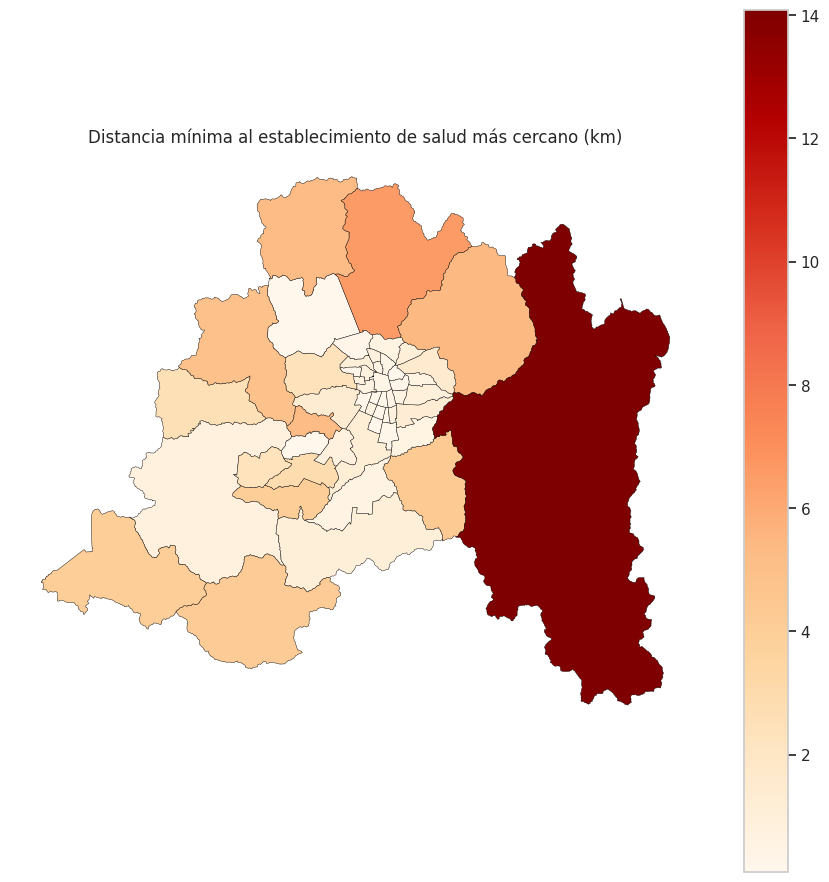

In [9]:
# Celda 9: mapa de distancia mínima a establecimientos de salud

comunas_access_map = comunas.merge(
    accesibilidad[["cod_comuna", "dist_min_salud_km"]],
    left_on="CUT_COM",
    right_on="cod_comuna",
    how="left",
)

fig, ax = plt.subplots(figsize=(9, 9))

comunas_access_map.plot(
    column="dist_min_salud_km",
    ax=ax,
    legend=True,
    cmap="OrRd",
    edgecolor="black",
    linewidth=0.3,
)

ax.set_title("Distancia mínima al establecimiento de salud más cercano (km)", fontsize=12)
ax.set_axis_off()

plt.tight_layout()
save_figure(fig, "mapa_dist_min_salud_km")
plt.show()


💾 Figura guardada en: /home/jovyan/outputs/figures/mapa_cobertura_salud.png


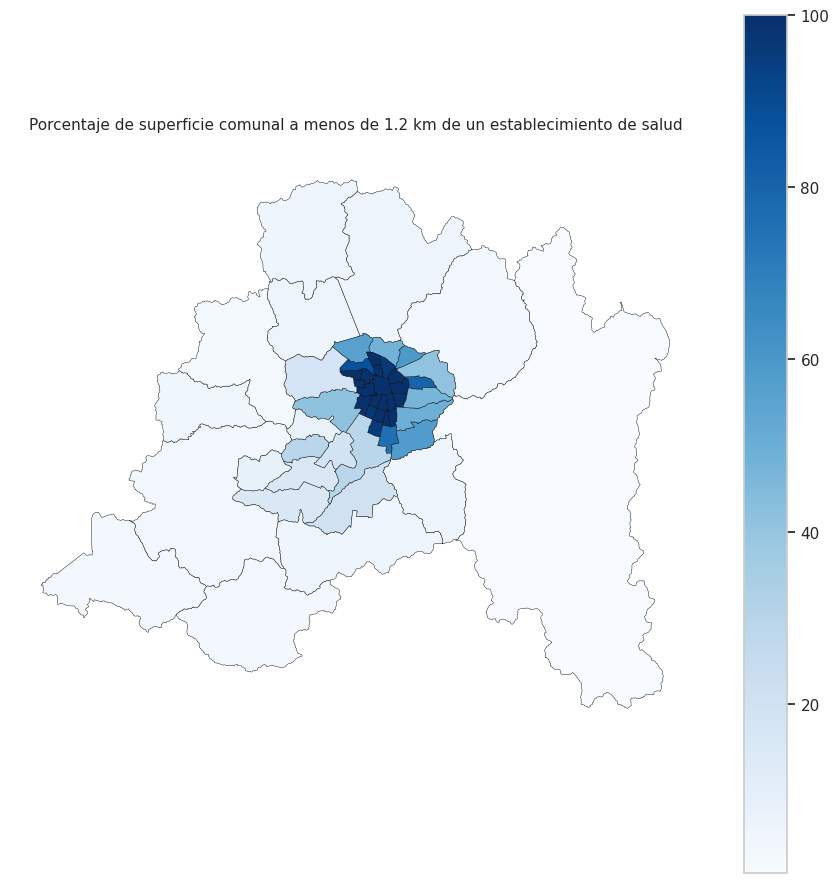

In [10]:
# Celda 10: mapa de porcentaje de superficie comunal cubierta por salud

comunas_cov_salud = comunas.merge(
    accesibilidad[["cod_comuna", "porc_cubierto_salud"]],
    left_on="CUT_COM",
    right_on="cod_comuna",
    how="left",
)

fig, ax = plt.subplots(figsize=(9, 9))

comunas_cov_salud.plot(
    column="porc_cubierto_salud",
    ax=ax,
    legend=True,
    cmap="Blues",
    edgecolor="black",
    linewidth=0.3,
)

ax.set_title(
    f"Porcentaje de superficie comunal a menos de {RADIO_SALUD_M/1000:.1f} km de un establecimiento de salud",
    fontsize=11,
)
ax.set_axis_off()

plt.tight_layout()
save_figure(fig, "mapa_cobertura_salud")
plt.show()


💾 Figura guardada en: /home/jovyan/outputs/figures/mapa_cobertura_supermercados.png


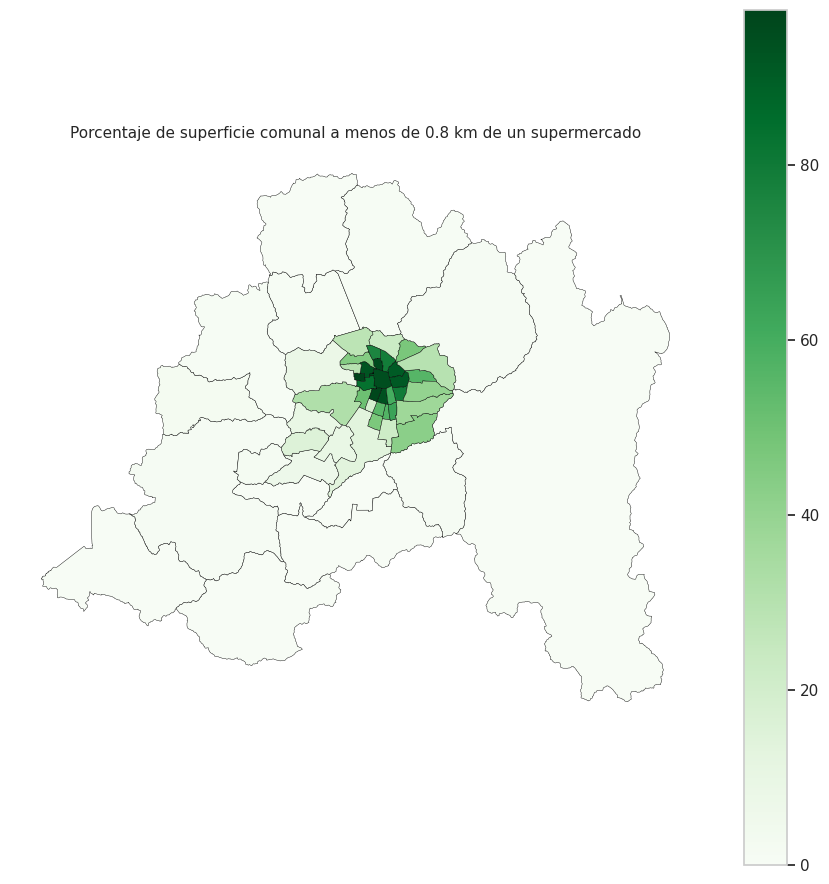

In [11]:
# Celda 11: mapa de porcentaje de superficie comunal cubierta por supermercados

comunas_cov_super = comunas.merge(
    accesibilidad[["cod_comuna", "porc_cubierto_supermercados"]],
    left_on="CUT_COM",
    right_on="cod_comuna",
    how="left",
)

fig, ax = plt.subplots(figsize=(9, 9))

comunas_cov_super.plot(
    column="porc_cubierto_supermercados",
    ax=ax,
    legend=True,
    cmap="Greens",
    edgecolor="black",
    linewidth=0.3,
)

ax.set_title(
    f"Porcentaje de superficie comunal a menos de {RADIO_SUPERMERCADOS_M/1000:.1f} km de un supermercado",
    fontsize=11,
)
ax.set_axis_off()

plt.tight_layout()
save_figure(fig, "mapa_cobertura_supermercados")
plt.show()


In [12]:
# Guardar métricas de accesibilidad por comuna
accesibilidad_path = PROCESSED_DATA / "accesibilidad_servicios.csv"
accesibilidad.to_csv(accesibilidad_path, index=False)
print(f"Métricas de accesibilidad guardadas en: {accesibilidad_path}")


Métricas de accesibilidad guardadas en: /home/jovyan/data/processed/accesibilidad_servicios.csv
